In [1]:
# read the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
testing_1 = pd.read_csv("/Users/yanbing_wang/Documents/Courses/2019 Fall/ML/hw1/Programming Assignment 1 Decision Trees attached files Sep 6, 2019 904 AM/cancer_datasets_v2/testing_1.csv")
testing_2 = pd.read_csv("/Users/yanbing_wang/Documents/Courses/2019 Fall/ML/hw1/Programming Assignment 1 Decision Trees attached files Sep 6, 2019 904 AM/cancer_datasets_v2/testing_2.csv")
training_1 = pd.read_csv("/Users/yanbing_wang/Documents/Courses/2019 Fall/ML/hw1/Programming Assignment 1 Decision Trees attached files Sep 6, 2019 904 AM/cancer_datasets_v2/training_1.csv")
training_2 = pd.read_csv("/Users/yanbing_wang/Documents/Courses/2019 Fall/ML/hw1/Programming Assignment 1 Decision Trees attached files Sep 6, 2019 904 AM/cancer_datasets_v2/training_2.csv")
validation_1 = pd.read_csv("/Users/yanbing_wang/Documents/Courses/2019 Fall/ML/hw1/Programming Assignment 1 Decision Trees attached files Sep 6, 2019 904 AM/cancer_datasets_v2/validation_1.csv")
validation_2 = pd.read_csv("/Users/yanbing_wang/Documents/Courses/2019 Fall/ML/hw1/Programming Assignment 1 Decision Trees attached files Sep 6, 2019 904 AM/cancer_datasets_v2/validation_2.csv")

### Classes and functions

In [2]:
import anytree
from anytree import Resolver, AnyNode, Node, RenderTree, Node, NodeMixin, search,PreOrderIter,PostOrderIter
import numpy as np
# class MyBaseClass(object):
#     foo = 4
    
class nodeClass(NodeMixin): # Add Node feature
    def __init__(self, name, dataframe, split_feature=None, split_threshold=None, parent=None, children = None,label=None):
        super(nodeClass, self).__init__()
        self.name = name
        self.dataframe = dataframe
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        self.label = label
        self.parent = parent
        if children:
            self.children = children

def split(node, split_feature, split_value):
    left = nodeClass(name = randomString(5), dataframe = node.dataframe[node.dataframe[split_feature] <= split_value])
    right = nodeClass(name = randomString(5), dataframe = node.dataframe[node.dataframe[split_feature] > split_value])
    return left,right

def gini_index(node):
    p1 = sum(node.dataframe.Is_Malignant)/len(node.dataframe)
    p0 = 1-p1
    gini = 1 - p0**2 - p1**2
    return gini

def total_gini(node1, node2):
    n = len(node1.dataframe)+len(node2.dataframe)
    weight_1 = len(node1.dataframe)/n
    weight_2 = len(node2.dataframe)/n
    weighted_gini = weight_1 * gini_index(node1) + weight_2 * gini_index(node2)
    return weighted_gini

def entropy(node):
    labels = node.dataframe['Is_Malignant']
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

def total_entropy(node1, node2):
    n = len(node1.dataframe)+len(node2.dataframe)
    weight_1 = len(node1.dataframe)/n
    weight_2 = len(node2.dataframe)/n
    weighted_entropy = weight_1 * entropy(node1) + weight_2 * entropy(node2)
    return weighted_entropy
    
def stopping_cond(node,gain_measure):
    if gain_measure == 'entropy':
        if entropy(node) == 0:
#             print('stop splitting because node is pure')
            return True
        elif len(node.dataframe) <= 1:
            print('stop splitting because of feature < 1')
            return True
        else:
            return False
    else:
        if gini_index(node) == 0:
            print('stop splitting because node is pure')
            return True
        elif len(node.dataframe) <= 1:
#             print('stop splitting because of feature < 1')
            return True
        else:
            return False

def get_split_values(data,column):
    split_values = []
    unique_values = np.unique(data[column])
    for index in range(len(unique_values)-1):
        middle_value = (unique_values[index+1]+unique_values[index])/2
        split_values.append(middle_value)
    return split_values
        
    
def computeOptimalSplit(node, gain_measure):
    if gain_measure == 'entropy':
        entropy_before = 999
        for feature in node.dataframe.columns[1:-1]:
            split_values = get_split_values(node.dataframe,feature)
            for value in split_values:
                left, right = split(node,feature,value)
                entropy_left, entropy_right = entropy(left), entropy(right)
                entropy_after = total_entropy(left,right)
                if entropy_after <= entropy_before:
                    best_feature, best_threshold = feature, value
                    entropy_before = entropy_after
        node.split_feature = best_feature
        node.split_threshold = best_threshold
        return best_feature, best_threshold 
    else:
        gini_before = 999
        for feature in node.dataframe.columns[1:-1]:
    #         node.dataframe = node.dataframe.sort_values(by=[feature])
            split_values = get_split_values(node.dataframe,feature)
            for value in split_values:
                left, right = split(node,feature,value)
                gini_left, gini_right = gini_index(left), gini_index(right)
                if (len(left.dataframe)==0) or (len(right.dataframe)==0):
                    print('length zero')
                else:
                    gini_after = total_gini(left,right)
                if gini_after <= gini_before:
                    best_feature, best_threshold = feature, value
                    gini_before = gini_after
        node.split_feature = best_feature
        node.split_threshold = best_threshold
        return best_feature, best_threshold 
    
    
def classify(leaf):
    labels = leaf.dataframe['Is_Malignant']
    unique_classes, counts_unique_classes = np.unique(labels, return_counts=True)
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    return classification

def predict(example, node):
#     stop traversing the tree
    if node.split_feature == None:
        return node.label
    else:
#         recursive part
        if example[node.split_feature].values[0] <= node.split_threshold:
            prediction = predict(example,node.children[0])
        else:
            prediction = predict(example, node.children[1])  
    return prediction

def get_predict_list(dataset, node):
    prediction = []
    for i in range(len(dataset)):
        example = dataset.iloc[i:i+1]
        prediction.append(predict(example,node))
    return prediction

def calc_accuracy(test_data, node):
    prediction = get_predict_list(test_data, node)
    eval_prediction = []
    correct_label = list(test_data['Is_Malignant'])
    for i in range(len(test_data)):
        example = test_data.iloc[i:i+1]
        eval_prediction.append(prediction[i]==correct_label[i])
    accuracy = sum(eval_prediction)/len(eval_prediction)
    return accuracy

def print_tree(node):
    for pre, _, node in RenderTree(node):
        treestr = u"%s%s" % (pre, '')
        print(treestr.ljust(8), node.split_feature, node.split_threshold, node.label)
    return


import random
import string
def randomString(stringLength):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

### Tree growth

In [3]:
def TreeGrowth(node,gain_measure):
    if stopping_cond(node, gain_measure) == True:
        node.label = classify(node)
        return node
    else:
        node.children = []
        best_feature, best_threshold = computeOptimalSplit(node,gain_measure)
#         print(best_feature, best_threshold)
        left, right = split(node, best_feature, best_threshold)
        left.parent = node
        right.parent = node

        left = TreeGrowth(left,gain_measure)
        right = TreeGrowth(right,gain_measure)
        
    return node

In [6]:
# root1 = nodeClass('root', dataframe = training_1)
root2 = nodeClass('root', dataframe = training_2)
# tree1_entropy = TreeGrowth(root1,'entropy')
tree2_entropy = TreeGrowth(root2,'entropy')
# tree1_gini = TreeGrowth(root1,'gini')
# tree2_gini = TreeGrowth(root2,'gini')

### Pruning a tree

In [8]:
import copy
from sklearn.metrics import f1_score

def possible_pruned_trees(base_tree):
    possible_tree_list = []
    node_name_list = [node.name for node in PostOrderIter(base_tree)]
#     del node_name_list[-1] # delete the root node from this list 
    for node_name in node_name_list:
        temp_tree = copy.deepcopy(base_tree)
        node_to_delete = search.find_by_attr(temp_tree,node_name)
        node_to_delete.children = [] # delete all the descendents of node_to_delete
        node_to_delete.label = classify(node_to_delete)
        node_to_delete.split_feature = None
        node_to_delete.split_threshold = None
        possible_tree_list.append(temp_tree)
    return possible_tree_list

def count_nodes(tree):
    return len(search.findall(tree, filter_=None))


def calc_f1score(test_data, node):
    prediction = []
    correct_label = list(test_data['Is_Malignant'])
    for i in range(len(test_data)):
        example = test_data.iloc[i:i+1]
        prediction.append(predict(example,node))
    f1score = f1_score(y_true = correct_label, y_pred = prediction, average = 'weighted')
    return f1score

def pruneSingleGreedyNode(validation_set, base_tree):
    possible_trees = possible_pruned_trees(base_tree)
    accuracy = calc_accuracy(validation_set,base_tree)
    new_accuracy = []
    node_length = []
    f1score_list = []
    for tree in possible_trees:
        new_accuracy.append(calc_accuracy(validation_set,tree))
        node_length.append(count_nodes(tree))
        f1score_list.append(calc_f1score(validation_set,tree))
    node_length = np.array(node_length)
    diff = np.array([x-accuracy for x in new_accuracy])
    # find the index of the best tree in possible tree list: max accuracy and smallest number of nodes
    best_indices = [i for i, x in enumerate(diff) if x == max(diff)]
    index = np.where(node_length == np.amin(node_length[best_indices]))[0][0]
    best_tree = possible_trees[index]
    return best_tree, new_accuracy,f1score_list,list(node_length)

def collect_evaluation_stats(validation_set, base_tree):
    best_tree, accuracy_list,f1score_list,node_length = pruneSingleGreedyNode(validation_set, base_tree)
    evaluation_stats = pd.DataFrame({'node_length': node_length,
                                     'accuracy': accuracy_list,
                                     'f1score': f1score_list
                                    })
    evaluation_stats = evaluation_stats.sort_values(by=['node_length'])
    return evaluation_stats

### data analysis

In [29]:
print('tree1_entropy_nodes:',count_nodes(tree1_entropy))
print('tree2_entropy_nodes:',count_nodes(tree2_entropy))
print('tree1_entropy_leaves:', len(tree1_entropy.leaves))
print('tree2_entropy_leaves:', len(tree2_entropy.leaves))
print('tree1_gini_nodes:',count_nodes(tree1_gini))
print('tree2_gini_nodes:',count_nodes(tree2_gini))
print('tree1_gini_leaves:', len(tree1_gini.leaves))
print('tree2_gini_leaves:', len(tree2_gini.leaves))

print('tree1_entropy accuracy: ',calc_accuracy(testing_1, tree1_entropy))
print('tree2_entropy accuracy: ',calc_accuracy(testing_2, tree2_entropy))
print('tree1_gini accuracy: ',calc_accuracy(testing_1, tree1_gini))
print('tree2_gini accuracy: ',calc_accuracy(testing_2, tree2_gini))

tree1_entropy_nodes: 33
tree2_entropy_nodes: 33
tree1_entropy_leaves: 17
tree2_entropy_leaves: 17
tree1_gini_nodes: 33
tree2_gini_nodes: 33
tree1_gini_leaves: 17
tree2_gini_leaves: 17
tree1_entropy accuracy:  0.9035087719298246
tree2_entropy accuracy:  0.9122807017543859
tree1_gini accuracy:  0.9035087719298246
tree2_gini accuracy:  0.9122807017543859


### plot f1 score and accuracy curve

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


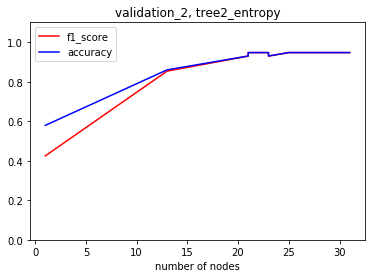

In [9]:
import matplotlib.pyplot as plt

stats = collect_evaluation_stats(validation_2, tree2_entropy)
plt.plot(stats.node_length, stats.f1score,'r',label = 'f1_score')
plt.plot(stats.node_length, stats.accuracy,'b',label = 'accuracy')
axes = plt.gca()
axes.set_ylim([0,1.1])
plt.xlabel('number of nodes')
plt.title('validation_2, tree2_entropy')
plt.legend()
plt.show()

### plot precision-recall and ROC curve

In [10]:
from sklearn.metrics import confusion_matrix
def get_stats(validation_set, base_tree):
    possible_trees = possible_pruned_trees(base_tree)
    accuracy = calc_accuracy(validation_set,base_tree)
    accuracy_list = []
    node_length = []
    f1score_list = []
    tn_list = []
    fp_list = []
    fn_list = []
    tp_list = []
    fp_rate = []
    tp_rate = []
    recall = []
    precision = []
    
    for tree in possible_trees:
        accuracy_list.append(calc_accuracy(validation_set,tree))
        node_length.append(count_nodes(tree))
        f1score_list.append(calc_f1score(validation_set,tree))
        y_true = np.array(validation_set['Is_Malignant'])
        y_pred = np.array(get_predict_list(validation_set, tree))
        m = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = m.ravel()
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)
        fp_rate.append(fp/(fp+tn))
        tp_rate.append(tp/(tp+fn))
        precision.append(tp/(tp+fp))
        recall.append(tp/(tp+fn))
    stats =  pd.DataFrame({'node_length': node_length,
                           'accuracy': accuracy_list,
                           'f1score': f1score_list,
                           'tn': tn_list,
                           'fp': fp_list,
                           'fn': fn_list,
                           'tp': tp_list,
                           'fp_rate': fp_rate,
                           'tp_rate': tp_rate,
                           'recall': recall,
                           'precision': precision
                                    })
    stats = stats.sort_values(by=['node_length'])
    return stats


### ROC curve

In [11]:
stats = get_stats(testing_2, tree2_entropy)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


In [12]:
stats = stats.sort_values(by=['node_length'])

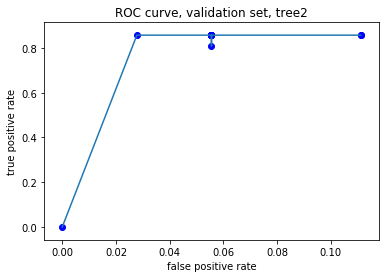

In [13]:
# average_precision = average_precision_score(y_true, y_scores)
stats = stats.fillna(1)
stats = stats.sort_values(by=['fp_rate'])
plt.plot(stats.fp_rate, stats.tp_rate)
plt.scatter(stats.fp_rate, stats.tp_rate,color='b')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.05])
plt.title('ROC curve, validation set, tree2')
plt.show()

### PR curve

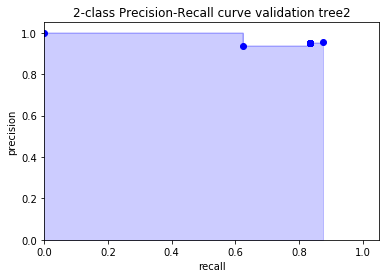

In [109]:
# average_precision = average_precision_score(y_true, y_scores)
stats = stats.fillna(1)
stats = stats.sort_values(by=['recall'])
plt.step(stats.recall, stats.precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(stats.recall, stats.precision, step='post', alpha=0.2,
                 color='b')
plt.scatter(stats.recall, stats.precision, color='b')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])

plt.title('2-class Precision-Recall curve validation tree2')
plt.show()

### find the best tree and plot it!

In [117]:
possible_trees = possible_pruned_trees(tree2_entropy)
for tree in possible_trees:
    print(count_nodes(tree))

31
31
29
25
31
21
19
31
31
27
11
31
31
29
25
1


In [118]:
# print_tree(possible_trees[-13])
# possible_trees[6]
tree1_copy = copy.deepcopy(possible_trees[10])
from anytree.dotexport import RenderTreeGraph
for node in PreOrderIter(tree1_copy):
    if node.label == None:
        string = str(node.name)+'\n'+str(node.split_feature)+'\n%s' % float('%.10g' % node.split_threshold)
        node.name = string
    else:
        node.name = str(node.name)+'\nClassify as '+str(node.label)

RenderTreeGraph(tree1_copy).to_picture("udo.png")


In [97]:
validation_1

,Is_Malignant,Radius__mean,Texture,Perimeter__mean,Area__mean,Smoothness__mean,Compactness__mean,Concavity__mean,Number_of_Concavities__mean,Symmetry__mean,...,Radius__max,Texture__max,Perimeter__max,Area__max,Smoothness__max,Compactness__max,Concavity__max,Number_of_Concavities__max,Symmetry__max,Factal_Dimension__max
0,0,12.340,12.27,78.94,468.5,0.09003,0.06307,0.029580,0.026470,0.1689,...,13.610,19.27,87.22,564.9,0.12920,0.20740,0.179100,0.107000,0.3110,0.07592
1,0,12.360,18.54,79.01,466.7,0.08477,0.06815,0.026430,0.019210,0.1602,...,13.290,27.49,85.56,544.1,0.11840,0.19630,0.193700,0.084420,0.2983,0.07185
2,0,13.200,17.43,84.13,541.6,0.07215,0.04524,0.043360,0.011050,0.1487,...,13.940,27.82,88.28,602.0,0.11010,0.15080,0.229800,0.049700,0.2767,0.07198
3,0,12.990,14.23,84.08,514.3,0.09462,0.09965,0.037380,0.020980,0.1652,...,13.720,16.91,87.38,576.0,0.11420,0.19750,0.145000,0.058500,0.2432,0.10090
4,0,11.130,16.62,70.47,381.1,0.08151,0.03834,0.013690,0.013700,0.1511,...,11.680,20.29,74.35,421.1,0.10300,0.06219,0.045800,0.040440,0.2383,0.07083
5,0,11.260,19.83,71.30,388.1,0.08511,0.04413,0.005067,0.005664,0.1637,...,11.930,26.43,76.38,435.9,0.11080,0.07723,0.025330,0.028320,0.2557,0.07613
6,0,12.220,20.04,79.47,453.1,0.10960,0.11520,0.081750,0.021660,0.2124,...,13.160,24.17,85.13,515.3,0.14020,0.23150,0.353500,0.080880,0.2709,0.08839
7,0,10.260,16.58,65.85,320.8,0.08877,0.08066,0.043580,0.024380,0.1669,...,10.830,22.04,71.08,357.4,0.14610,0.22460,0.178300,0.083330,0.2691,0.09479
8,0,11.810,17.39,75.27,428.9,0.10070,0.05562,0.023530,0.015530,0.1718,...,12.570,26.48,79.57,489.5,0.13560,0.10000,0.088030,0.043060,0.3200,0.06576
9,0,8.618,11.79,54.34,224.5,0.09752,0.05272,0.020610,0.007799,0.1683,...,9.507,15.40,59.90,274.9,0.17330,0.12390,0.116800,0.044190,0.3220,0.09026


In [21]:
tree1_entropy.children

(<__main__.nodeClass at 0x1a1b6baf30>, <__main__.nodeClass at 0x1a1bd230d8>)